# Building and evaluating a discrete-time neural network

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import torch

## Load the support dataset

In [2]:
def load_support_dataset(random_state=0):

    FILL_VALUES = {
        'alb': 3.5,
        'pafi': 333.3,
        'bili': 1.01,
        'crea': 1.01,
        'bun': 6.51,
        'wblc': 9.,
        'urine': 2502.
    }

    COLUMNS_TO_DROP = [
        'aps', 'sps', 'surv2m', 'surv6m', 'prg2m',
        'prg6m', 'dnr', 'dnrday', 'sfdm2', 'hospdead'
    ]

    df = (
        pd.read_csv('../data/support2.csv')
        .drop(COLUMNS_TO_DROP,axis=1)
        .fillna(value=FILL_VALUES)
        .sample(frac=1, random_state=random_state)
    )

    # one-hot encode categorical variables
    df = pd.get_dummies(df, dummy_na=True)

    # fill missing values to the median
    df = df.fillna(df.median())

    # standardize numeric columns
    numeric_cols = df.dtypes == 'float64'
    df.loc[:, numeric_cols] = df.loc[:, numeric_cols].transform(
        lambda x: (x - x.mean()) / x.std())
    
    features = (
        df
        .drop(['death', 'd.time'], axis=1)
        .values
        .astype(float)
    )
    
    event_indicator = df['death'].values.astype(float)
    event_time = df['d.time'].values.astype(float)

    return features, event_indicator, event_time

In [3]:
X, s, t = load_support_dataset()

In [4]:
test_idx = len(X) * 4 // 5

train_X, train_s, train_t = (arr[:test_idx] for arr in (X, s, t))
test_X, test_s, test_t = (arr[test_idx:] for arr in (X, s, t))

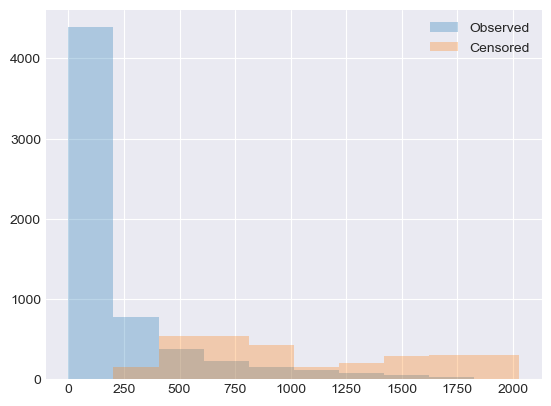

In [5]:
BIN_BOUNDARIES = np.arange(11) * (t.max() / 10)

plt.hist(t[s == 1], alpha=.3, bins=BIN_BOUNDARIES, label='Observed')
plt.hist(t[s == 0], alpha=.3, bins=BIN_BOUNDARIES, label='Censored')
plt.legend()
plt.show()

# Define a Simple NN

In [6]:
class DiscreteTimeNN(torch.nn.Module):

    def __init__(self, hidden_layer_sizes, num_bins):
        super(DiscreteTimeNN, self).__init__()

        self.encoder_layers = [
            torch.nn.LazyLinear(size)
            for size in hidden_layer_sizes
        ]
        
        self.activation = torch.nn.ReLU()
        self.prediction_head = torch.nn.LazyLinear(num_bins + 1)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, x):
        
        for layer in self.encoder_layers:
            x = layer(x)
            x = self.activation(x)
            
        x = self.prediction_head(x)
        x = self.softmax(x)

        return x

## Define the Negative Log-Likelihood (Loss) for the Discrete Time Failure Time Model

In [7]:
class DiscreteFailureTimeNLL(torch.nn.Module):
    
    def __init__(self, bin_boundaries, tolerance=1e-8):
        super(DiscreteFailureTimeNLL,self).__init__()
        
        self.bin_starts = torch.tensor(bin_boundaries[:-1])
        self.bin_ends = torch.tensor(bin_boundaries[1:])
        
        self.bin_lengths = self.bin_ends - self.bin_starts
        
        self.tolerance = tolerance
        
    def _discretize_times(self, times):

        return (
            (times[:, None] > self.bin_starts[None, :])
            & (times[:, None] <= self.bin_ends[None, :])
        )

    def _get_proportion_of_bins_completed(self, times):

        return torch.maximum(
            torch.minimum(
                (times[:, None] - self.bin_starts[None, :]) / self.bin_lengths[None, :],
                torch.tensor(1)
            ),
            torch.tensor(0)
        )
    
    def forward(self, predictions, event_indicators, event_times):

        event_likelihood = torch.sum(
            self._discretize_times(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance

        nonevent_likelihood = 1 - torch.sum(
            self._get_proportion_of_bins_completed(event_times) * predictions[:, :-1],
            -1
        ) + self.tolerance
        
        log_likelihood = event_indicators * torch.log(event_likelihood)
        log_likelihood += (1 - event_indicators) * torch.log(nonevent_likelihood)
        
        return -1. * torch.mean(log_likelihood)

In [8]:
model = DiscreteTimeNN((100, ), 10)
loss_fn = DiscreteFailureTimeNLL(BIN_BOUNDARIES)
optimizer = torch.optim.Adam(model.parameters())

/Users/mme4/miniforge3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
def get_batches(*arrs, batch_size=1):
    l = len(arrs[0])
    for ndx in range(0, l, batch_size):
        yield (torch.tensor(arr[ndx:min(ndx + batch_size, l)], dtype=torch.float) for arr in arrs)

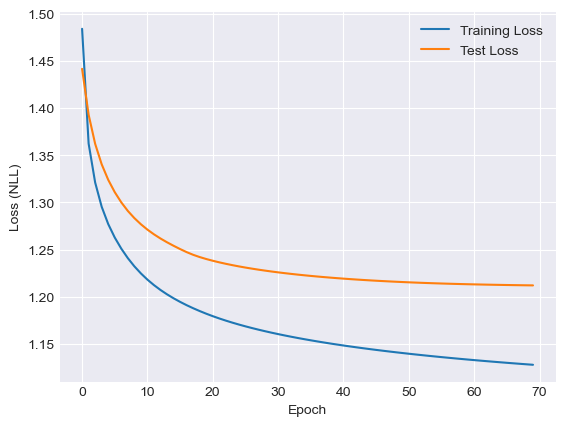

In [10]:
NUM_EPOCHS = 70

train_loss = []
test_loss = []

for epoch_idx in range(NUM_EPOCHS):
    
    epoch_train_loss = []
    epoch_test_loss = []

    for batch_X, batch_s, batch_t in get_batches(train_X, train_s, train_t, batch_size=100):

        optimizer.zero_grad()

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        epoch_train_loss.append(loss.item())
        
    for batch_X, batch_s, batch_t in get_batches(test_X, test_s, test_t, batch_size=100):

        # Make predictions for this batch
        batch_predictions = model(batch_X)
        
        # Compute the loss and its gradients
        loss = loss_fn(batch_predictions, batch_s, batch_t)
        
        # Gather data and report
        epoch_test_loss.append(loss.item())
        
    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))
            
    print('Completed epoch %i; train loss = %.3f; test loss = %.3f' % (
        epoch_idx, train_loss[-1], test_loss[-1]), end='\r')
          
plt.plot(np.arange(len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.arange(len(test_loss)), test_loss, label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (NLL)')
plt.legend()
plt.show()

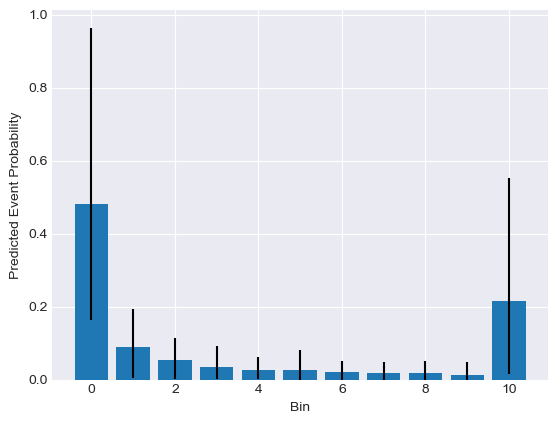

In [11]:
test_predictions = (
    model(torch.tensor(test_X, dtype=torch.float))
    .detach()
    .numpy()
)

pred_mean = np.mean(test_predictions, axis=0)
pred_lower = np.percentile(test_predictions, 2.5, axis=0)
pred_upper = np.percentile(test_predictions, 97.5, axis=0)

plt.bar(
    np.arange(11),
    np.mean(test_predictions, axis=0),
    yerr=np.stack([
        pred_mean - pred_lower,
        pred_upper - pred_mean
    ])
)

plt.xlabel('Bin')
plt.ylabel('Predicted Event Probability')
plt.show()

In [12]:
import sys
sys.path.append('../utils')
from tte_measures import kaplan_meier, xCI, xAUCt, xROCt, xAPt, xPRt

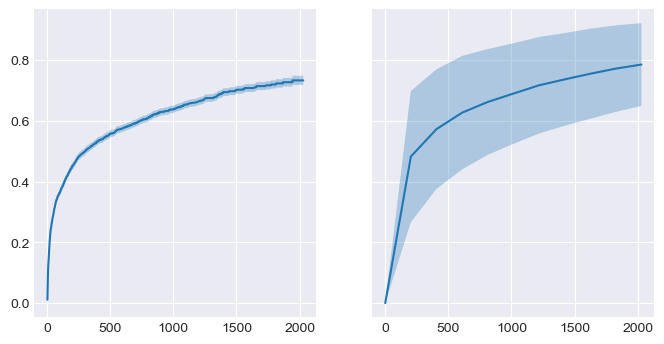

In [23]:
times = BIN_BOUNDARIES[1:]

cumulative_predicted_risk = np.cumsum(test_predictions, axis=1)[:, :-1]

cp_mean = [0] + list(cumulative_predicted_risk.mean(axis=0))
cp_std = [0] + list(cumulative_predicted_risk.std(axis=0))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

km_times, km_mean, km_var = kaplan_meier(test_s, test_t)

ax[0].plot(km_times, 1 - km_mean)
ax[0].fill_between(km_times, 1 - km_mean - np.sqrt(km_var), 1 - km_mean + np.sqrt(km_var), alpha=.3)

ax[1].plot([0] + list(times), cp_mean)
ax[1].fill_between(
    [0] + list(times),
    np.array(cp_mean) - np.array(cp_std),
    np.array(cp_mean) + np.array(cp_std),
    alpha=.3
)

plt.show()

/Users/mme4/projects/collaborative-ml-notebooks/notebooks/../utils/tte_measures.py:154: RuntimeWarning: invalid value encountered in divide
  return np.sum(correctly_ranked, axis=(0, 1)) / np.sum(valid, axis=(0, 1))


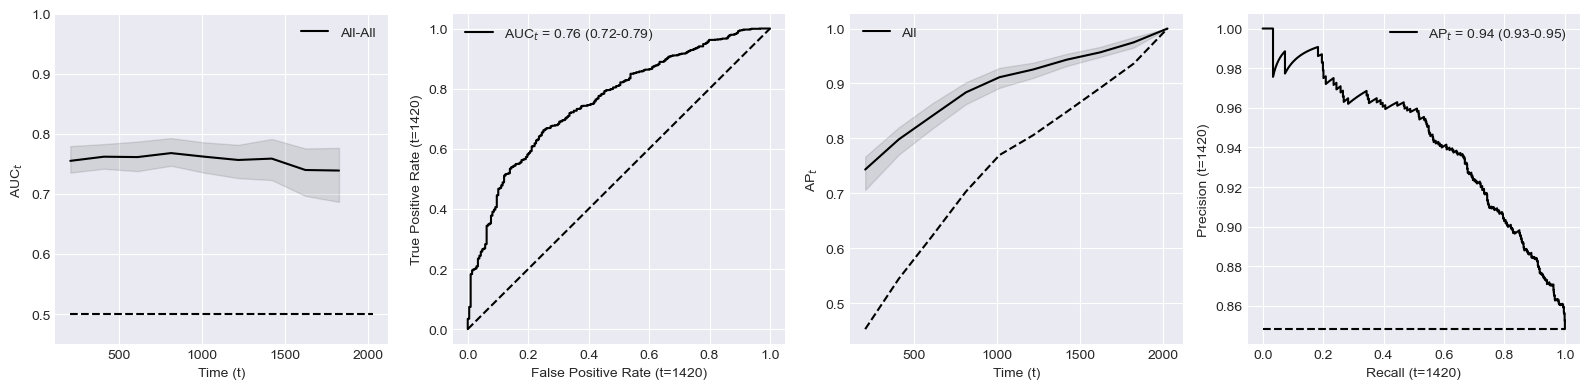

In [24]:
n_bootstrap_samples = 50

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

times = BIN_BOUNDARIES[1:]
time_idx = 6
time = times[time_idx]

cumulative_predicted_risk = np.cumsum(test_predictions, axis=1)[:, :-1]

auct, ci_low, ci_high = xAUCt(
    test_s == 1, test_t, cumulative_predicted_risk, times,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[0].plot(times, auct, 'k-', label='All-All')
ax[0].fill_between(times, ci_low, ci_high, color='k', alpha=.1)

tprt, fprt, _ = xROCt(
    test_s == 1, test_t, cumulative_predicted_risk[:, time_idx], time
)

ax[1].plot(
    fprt, tprt, 'k-',
    label='AUC$_t$ = %.2f (%.2f-%.2f)' % (
        auct[time_idx], ci_low[time_idx], ci_high[time_idx]
    )
)

(apt, prevt), (apt_low, prev_low), (apt_high, prev_high) = xAPt(
    test_s == 1, test_t, cumulative_predicted_risk, times,
    return_prevalence=True,
    n_bootstrap_samples=n_bootstrap_samples
)

ax[2].plot(times, apt, 'k-', label='All')
ax[2].fill_between(times, apt_low, apt_high, color='k', alpha=.1)
ax[2].plot(times, prevt, 'k--')#, label='Prevalence at t')

recallt, precisiont, _, prevt = xPRt(
    test_s == 1, test_t, cumulative_predicted_risk[:, time_idx], time
)

ax[3].plot(
    recallt, precisiont, 'k-',
    label='AP$_t$ = %.2f (%.2f-%.2f)' % (
        apt[time_idx], apt_low[time_idx], apt_high[time_idx]
    )
)

ax[3].plot([0, 1], [prevt, prevt], 'k--')#, label='Prevalence at t')

ax[0].plot(times, times * 0 + .5, 'k--')
ax[0].set_ylim([0.45, 1.])
ax[0].set_ylabel('AUC$_t$')
ax[0].set_xlabel('Time (t)')
ax[0].legend()

ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_ylabel('True Positive Rate (t=%i)' % time)
ax[1].set_xlabel('False Positive Rate (t=%i)' % time)
ax[1].legend()

ax[2].set_ylabel('AP$_t$')
ax[2].set_xlabel('Time (t)')
ax[2].legend()

ax[3].set_ylabel('Precision (t=%i)' % time)
ax[3].set_xlabel('Recall (t=%i)' % time)
ax[3].legend()

plt.tight_layout()
plt.show()